In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'1.13.0'

In [2]:
device = torch.device('cuda')  if torch.cuda.is_available() else torch.device('cpu') 

In [3]:
weight = 0.3
bias = 0.9

x = torch.arange(0,1,0.01).unsqueeze(dim=1)
y = weight*x + bias

x[:5],y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120]]))

In [4]:
train_split = int(0.8*len(x))
print(f'train test split {train_split}% {100-train_split}%')
x_train,y_train = x[:train_split],y[:train_split] 
x_test,y_test = x[train_split:],y[train_split:]

print(f'train - {len(x_train)}')
print(f'test - {len(x_test)}')

train test split 80% 20%
train - 80
test - 20


In [5]:
def plot_predictions(train_data=x_train, 
                     train_labels=y_train, 
                     test_data=x_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="y", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

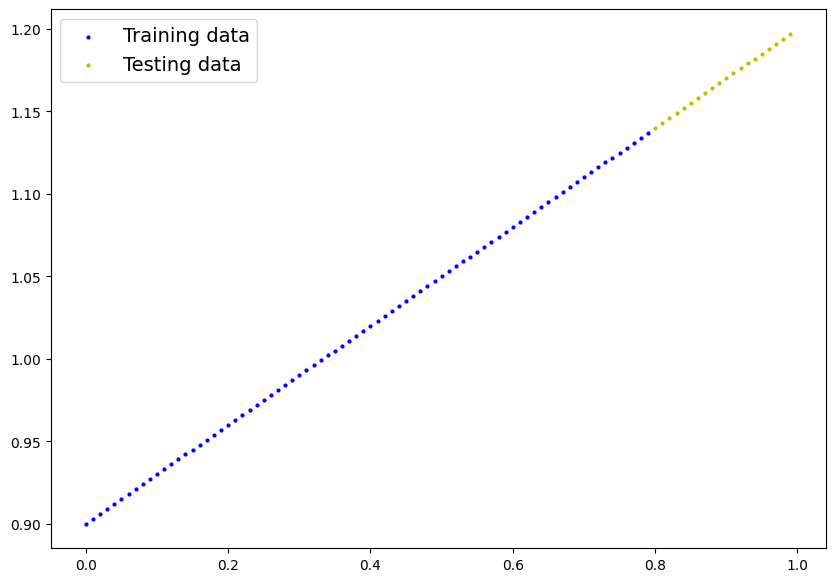

In [6]:
plot_predictions()

## linear regression

In [7]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,dtype=float),requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1,dtype=float),requires_grad=True)
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [8]:
torch.manual_seed(42)

model_notrain = LinearRegression()

print(list(model_notrain.parameters()))
print(model_notrain.state_dict())

[Parameter containing:
tensor([0.3367], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.1288], dtype=torch.float64, requires_grad=True)]
OrderedDict([('weight', tensor([0.3367], dtype=torch.float64)), ('bias', tensor([0.1288], dtype=torch.float64))])


In [9]:
# inference/prediction

with torch.inference_mode(): 
    y_preds = model_notrain(x_test)
    
print(y_preds[:5])

tensor([[0.3982],
        [0.4015],
        [0.4049],
        [0.4083],
        [0.4116]], dtype=torch.float64)


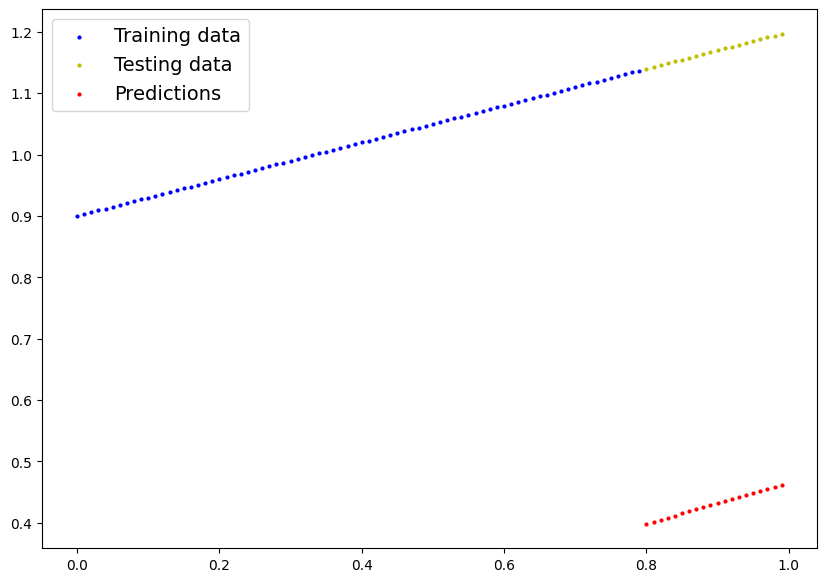

In [10]:
plot_predictions(predictions=y_preds)

## training

In [11]:
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss
optimizer = torch.optim.SGD(params=model_notrain.parameters(),lr=0.01)

In [12]:
torch.manual_seed(42)

epochs = 1000

train_loss_values = list()
test_loss_values = list()
epoch_count = list()

for epoch in range(epochs):
    model_notrain.train() # put model in training mode
    y_pred = model_notrain(x_train)
    loss = loss_fn(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_notrain.eval()
    
    with torch.inference_mode():
        test_pred = model_notrain(x_test)
        
        test_loss = loss_fn(test_pred,y_test.type(torch.float))
        
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.7566978850205477 | MAE Test Loss: 0.7248174654184888 
Epoch: 10 | MAE Train Loss: 0.6410953851993335 | MAE Test Loss: 0.5894649655504061 
Epoch: 20 | MAE Train Loss: 0.5254928853781197 | MAE Test Loss: 0.4541124656823234 
Epoch: 30 | MAE Train Loss: 0.40989038555690555 | MAE Test Loss: 0.31875996581424076 
Epoch: 40 | MAE Train Loss: 0.29428788573569165 | MAE Test Loss: 0.18340746594615806 
Epoch: 50 | MAE Train Loss: 0.1786853859144775 | MAE Test Loss: 0.04805496607807498 
Epoch: 60 | MAE Train Loss: 0.07658555325353075 | MAE Test Loss: 0.07274122116104585 
Epoch: 70 | MAE Train Loss: 0.057435320130017196 | MAE Test Loss: 0.11017109590784802 
Epoch: 80 | MAE Train Loss: 0.052553712033635194 | MAE Test Loss: 0.11581578331597756 
Epoch: 90 | MAE Train Loss: 0.0489758973288615 | MAE Test Loss: 0.11232693318310327 
Epoch: 100 | MAE Train Loss: 0.0455426820761507 | MAE Test Loss: 0.10467905803297743 
Epoch: 110 | MAE Train Loss: 0.0421156257808174 | MAE Test Lo

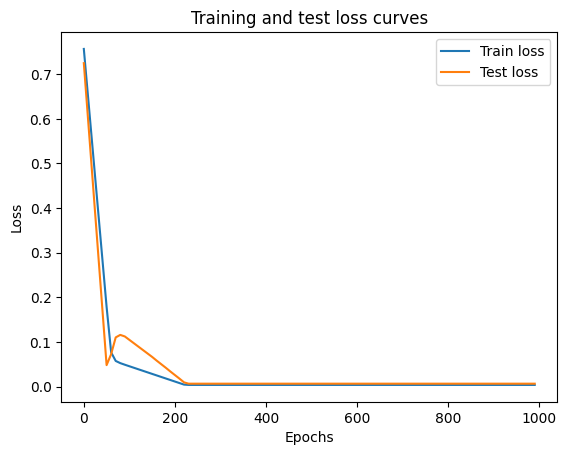

In [13]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [14]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_notrain.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.3067], dtype=torch.float64)), ('bias', tensor([0.9011], dtype=torch.float64))])

And the original values for weights and bias are:
weights: 0.3, bias: 0.9


In [15]:
model_notrain.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    x_test= x_test.to(device)
    y_preds = model_notrain(x_test)
y_preds

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740],
        [1.1771],
        [1.1801],
        [1.1832],
        [1.1863],
        [1.1893],
        [1.1924],
        [1.1955],
        [1.1985],
        [1.2016],
        [1.2047]], dtype=torch.float64)

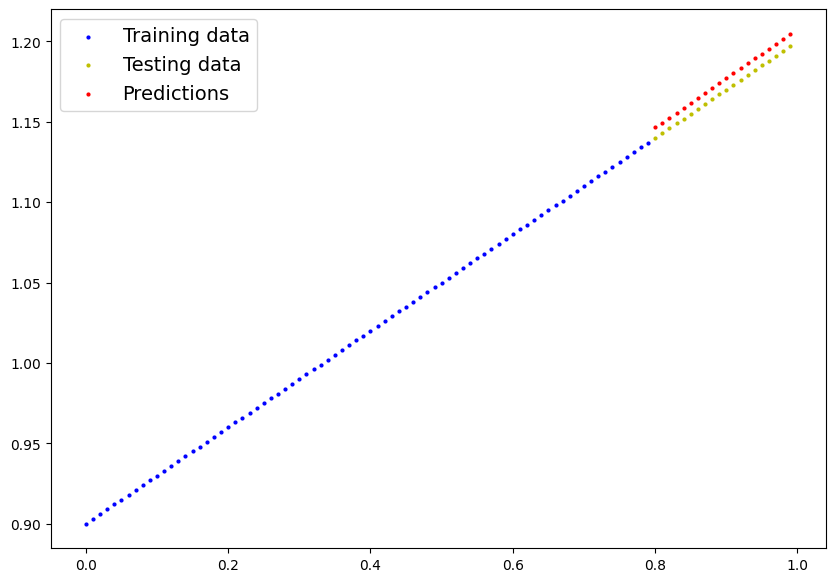

In [16]:
plot_predictions(predictions=y_preds)


## saving and loading model

In [21]:
import os
from pathlib import Path


model_path = Path('models')

model_path.mkdir(parents=True, exist_ok=True)


model_name = '01_basics_linear_regression.pt'

torch.save(obj=model_notrain.state_dict(),f=os.path.join(model_path,model_name))

In [23]:
loaded_model = LinearRegression()

loaded_model.load_state_dict(torch.load(f=os.path.join(model_path,model_name)))

loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(x_test)
    
y_preds == loaded_model_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])